# Step 0: Imports

In [2]:
from collections import deque
import pickle
# using tqdm.auto glitches out collaborative editing
from tqdm import tqdm

import torch
import torch.nn as nn
import pickle
from math import sqrt
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
# %matplotlib widget
torch.manual_seed(42)

import os
from IPython.display import clear_output
import ipdb

import random
random.seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
assert device.type == 'cuda', "CUDA is not available. Please check your GPU setup."

In [3]:
SEQ_LEN = 65 # means 32 edges, final token is the target vertex
PAD_TOKEN = 0
AVG_DEG = 2
MAX_VTXS = SEQ_LEN//AVG_DEG + 1 # 32 (exclusive)
MIN_VTXS = 8
MAX_TUNE_VTXS = 16
PAD_TOKEN = 0
# vertices are labelled 1,2,...,63
# we also have a padding token which is 0.

# Step 1: Generate synthetic data

In [18]:
# original task data
# the data will be edge lists
# like this: [1 3 1 5 2 4 0 0 0 0 2]
# this represents edges (1,3), (1,5) (2,4)
# (the zeros are just padding tokens)
# the final 2 means which vertex we're going to 

# the label is the shortest distance from vtx 1 to vtx 2
# or "number of vertices" if no path exists

def random_graph(n):
    edge_list = []
    adjacencies = [set() for _ in range(n+1)]
    indices = [random.randint(1, n-1) for _ in range(AVG_DEG * (n-1))]
    for i in range(0, len(indices), 2):
        u = indices[i]
        v = indices[i + 1]
        if u != v:
            edge_list += [u,v]
            adjacencies[u].add(v)
            adjacencies[v].add(u)

    edge_list += [PAD_TOKEN]*(SEQ_LEN-len(edge_list))
    return edge_list, adjacencies

"""
input: G, represented as an adjacency list
output: [number of vertices]+[d(1,i) for i in range(n)] if target=None
if target is set to some value, then we instead just output that specific distance
"""
def SSSP(n, G, target=2):
    dist = [n for _ in G]
    dist[1] = 0
    frontier = deque()
    frontier.append(1)
    while len(frontier) > 0:
        vtx = frontier.popleft()
        for x in G[vtx]:
            if dist[x] == n:
                dist[x] = 1 + dist[vtx]
                frontier.append(x)
                if x == target:
                    return dist[target]
    if target is not None:
        return dist[target]
    else:
        return dist

def mkbatch(size):
    graphs1 = []
    distance1 = []
    
    for i in range(size):
        n = random.randrange(MIN_VTXS, MAX_VTXS)
        edge_list, adj_list = random_graph(n)
        dist = SSSP(n, adj_list)
        edge_list[-1] = 2 # target token
        graphs1.append(edge_list)
        distance1.append(dist)
    
    data = torch.tensor(graphs1, device=device)
    labels = torch.tensor(distance1, dtype=torch.float32, device=device)
    padding = data == PAD_TOKEN
    return data, labels, padding

def vertices_on_shortest_12_path(n, G, target=2):
    dist = [n for _ in G]
    parent = [-1 for _ in G]
    dist[1] = 0
    frontier = deque()
    frontier.append(1)
    while len(frontier) > 0:
        vtx = frontier.popleft()
        for x in G[vtx]:
            if dist[x] == n:
                parent[x] = vtx
                dist[x] = 1 + dist[vtx]
                frontier.append(x)
                if x == target:
                    path = [x]
                    while parent[x] != -1:
                        x = parent[x]
                        path.append(x)
                    return list(reversed(path))
    return []

def mktunebatch(size):
    graphs2 = []
    distance2 = []
    
    for i in range(size):
        n = random.randrange(MIN_VTXS, MAX_TUNE_VTXS)
        while True:
            edge_list, adj_list = random_graph(n)
            path = vertices_on_shortest_12_path(n, adj_list)
            if len(path) > 1:
                target_vtx_idx = random.randrange(1, len(path))
                target_vtx = path[target_vtx_idx]
                edge_list[-1] = target_vtx
                graphs2.append(edge_list)
                distance2.append(target_vtx_idx)
                break
    
    data = torch.tensor(graphs2, device=device)
    labels = torch.tensor(distance2, dtype=torch.float32, device=device)
    padding = data == PAD_TOKEN
    return data, labels, padding

(array([255.,   0., 298.,   0., 231.,   0., 210.,   0., 123.,   0.,  63.,
          0.,  31.,   0.,  46.,   0.,  39.,   0.,  35.,   0.,  40.,   0.,
         35.,   0.,  44.,   0.,  24.,   0.,  37.,   0.,  26.,   0.,   0.,
         39.,   0.,  31.,   0.,  31.,   0.,  38.,   0.,  34.,   0.,  36.,
          0.,  33.,   0.,  33.,   0.,  22.,   0.,  38.,   0.,  28.,   0.,
         34.,   0.,  26.,   0.,  30.,   0.,  26.,   0.,  32.]),
 array([ 1.      ,  1.484375,  1.96875 ,  2.453125,  2.9375  ,  3.421875,
         3.90625 ,  4.390625,  4.875   ,  5.359375,  5.84375 ,  6.328125,
         6.8125  ,  7.296875,  7.78125 ,  8.265625,  8.75    ,  9.234375,
         9.71875 , 10.203125, 10.6875  , 11.171875, 11.65625 , 12.140625,
        12.625   , 13.109375, 13.59375 , 14.078125, 14.5625  , 15.046875,
        15.53125 , 16.015625, 16.5     , 16.984375, 17.46875 , 17.953125,
        18.4375  , 18.921875, 19.40625 , 19.890625, 20.375   , 20.859375,
        21.34375 , 21.828125, 22.3125  , 22.7968

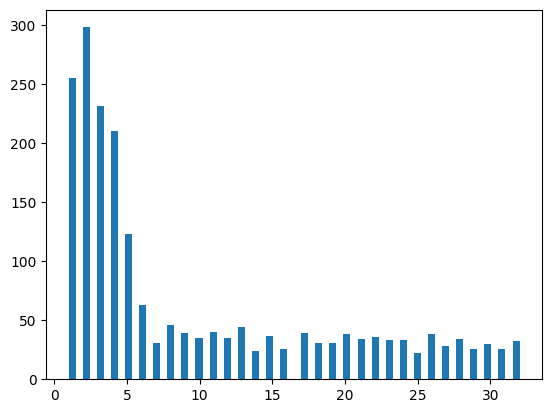

In [41]:
plt.hist(mkbatch(2048)[1].cpu(), bins=64)

(array([1162.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,  525.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,  242.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,   87.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,   22.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    7.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           3.]),
 array([1.     , 1.09375, 1.1875 , 1.28125, 1.375  , 1.46875, 1.5625 ,
        1.65625, 1.75   , 1.84375, 1.9375 , 2.03125, 2.125  , 2.21875,
        2.3125 , 2.40625, 2.5    , 2.59375, 2.6875 , 2.78125, 2.875  ,
        2.96875, 3.0625 , 3.15625, 3.25   , 3.34375, 3.4375 , 3.53125,
        3.625  , 3.71875, 3.8125 , 3.90625, 4.     , 4.09375, 4.1875 ,
        4.28125, 4.375  , 4.46875, 4.5625 , 4.65625, 4.75   , 4.84375,
        4.9375 , 5.03125, 5.125  , 5.21875, 5.3125 , 5.40625

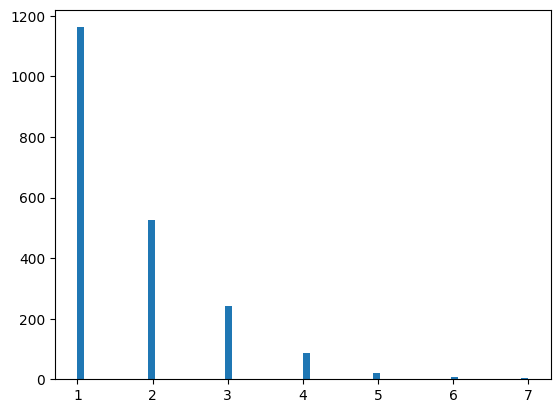

In [42]:
plt.hist(mktunebatch(2048)[1].cpu(), bins=64)

# Step 2: Define Transformer Model

In [5]:
class TransformerModel(nn.Module):
    def __init__(self, input_dim, model_dim, output_dim, num_heads, num_layers, seq_len, device, dropout):
        super().__init__()
        self.embedding = nn.Embedding(input_dim, model_dim//2)
        # seq_len is odd
        self.fancy_encoding = torch.repeat_interleave(torch.rand((1, seq_len // 2 + 1, model_dim // 2), device=device), 2, dim=1)
        # cut off last element since the target vertex is not repeated
        self.fancy_encoding = self.fancy_encoding[:, :seq_len, :]
        
        self.model_dim = model_dim
        self.seq_len = seq_len
        self.device = device

        encoder_layer = nn.TransformerEncoderLayer(d_model=model_dim, nhead=num_heads,
                                                   dim_feedforward=model_dim*4,
                                                   dropout=dropout, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers)

        self.fc_out = nn.Linear(model_dim*seq_len, output_dim)

    def forward(self, src, key_padding_mask):
        batch_size, src_len = src.size(0), src.size(1)
        embed = self.embedding(src)
        src = torch.cat((embed * sqrt(self.model_dim), self.fancy_encoding.repeat((batch_size, 1, 1))), dim=2)

        output = self.transformer_encoder(src, src_key_padding_mask=key_padding_mask)
        output[key_padding_mask] = 0 # Hack to stop no_grad problem
        flat_output = torch.flatten(output, start_dim=1, end_dim=2)
        output = self.fc_out(flat_output)
        return output

# Step 3: Make Model

In [11]:
# PARAMS
VOCAB_SIZE = 1 + MAX_VTXS # one more than the max number of vertices
MODEL_DIM = 64 # Dimension of model (embedding and transformer)
NEPOCHS = 1000
BSZ = 2048 # Batch size
BPE = 64 # Batches per epoch
LR = 0.003
WD = 0.002
NHEADS = 4
NLAYERS = 12
DROPOUT = 0.2
model = TransformerModel(input_dim=VOCAB_SIZE, model_dim=MODEL_DIM,
                         output_dim=1, num_heads=NHEADS,
                         num_layers=NLAYERS, seq_len=SEQ_LEN,
                         dropout=DROPOUT, device=device).to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=WD)

trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Training data: {NEPOCHS*BSZ*BPE//10**6}M")
print(f"Trainable parameters in the model: {trainable_params//1000}K")

Training data: 131M
Trainable parameters in the model: 605K


# Step 4: Train the Model for the first task

In [46]:
def evaluate():
    model.eval()
    test_loss = 0
    with torch.no_grad():
        batch_src, batch_labels, batch_padding_mask = mkbatch(BSZ)
        output = model(batch_src, batch_padding_mask)
        loss = criterion(output.squeeze(1), batch_labels)
    return loss.item()

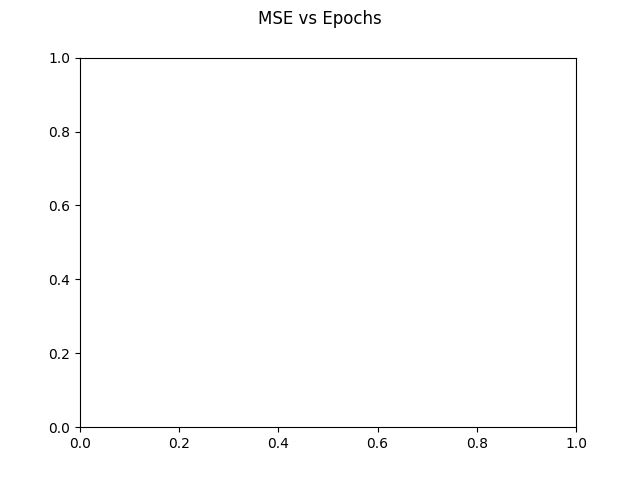

In [51]:
# This has to be in a separate cell for some weird event loop reasons
%matplotlib widget
fig,ax = plt.subplots()
fig.suptitle('MSE vs Epochs')
plt.show()
%matplotlib inline

In [12]:
train_err = []
test_err = []

for epoch in range(NEPOCHS):
    model.train()
    train_loss = 0
    for i in tqdm(range(BPE)):
        batch_src, batch_labels, batch_padding_mask = mkbatch(BSZ)
        optimizer.zero_grad()
        output = model(batch_src, batch_padding_mask)
        loss = criterion(output.squeeze(1), batch_labels)
        train_loss += loss.item() / BPEREPOCH
        loss.backward()
        optimizer.step()

    test_loss = evaluate()
            
    test_err.append(test_loss)
    train_err.append(train_loss)
    with open("loss", "a") as f:
        f.write(f"{train_loss} {test_loss}\n")
    print(f"Epoch {epoch + 1}/{NEPOCHS} \t Train Err: {train_loss:.4f} \t Test Err: {test_loss:.4f}")
    ax.plot(train_err, label='Train', color='blue')
    ax.plot(test_err, label='Test', color='red')
    ax.set_xlabel('Epochs')
    ax.set_ylabel('MSE')
    fig.canvas.draw()

    if epoch % 100 == 99:
        torch.save(model.state_dict(), f"model_weights_{epoch}.pth")

  0%|                                                    | 0/64 [00:00<?, ?it/s]


NameError: name 'mkbatch' is not defined

In [57]:
evaluate()

177.23538208007812

In [ ]:
batch_src, batch_labels, batch_padding_mask = next(iter(train_loader))
output = model(batch_src, batch_padding_mask)
batch_src[0], batch_labels[0], output[0]

In [ ]:
plt.hist(output.detach().cpu().numpy().flatten(),bins=32)

In [ ]:
plt.hist(label.detach().cpu().numpy().flatten(),bins=32)

In [ ]:
plt.scatter(batch_labels.detach().cpu().numpy().flatten(),output.detach().cpu().numpy().flatten())

In [ ]:
batch_src2, batch_labels2, batch_padding_mask2 = next(iter(test_loader))
output2 = model(batch_src2, batch_padding_mask2)
loss = criterion(output2.squeeze(1), batch_labels2)
batch_src2[0], batch_labels2[0], output2[0], loss

In [ ]:
plt.scatter(batch_labels2.detach().cpu().numpy().flatten(),output2.detach().cpu().numpy().flatten())

# Step 5: Fine Tune

In [ ]:
N_TUNE_EPOCHS = 100
TUNE_LR = 0.003
TUNE_WD = 0.002

tune_criterion = nn.MSELoss()
tune_optimizer = torch.optim.Adam(model.parameters(), lr=TUNE_LR, weight_decay=TUNE_WD)

In [ ]:
def tuneevaluate():
    model.eval()
    test_loss = 0
    with torch.no_grad():
        batch_src, batch_labels, batch_padding_mask = mktunebatch(BSZ)
        output = model(batch_src, batch_padding_mask)
        loss = criterion(output.squeeze(1), batch_labels)
    return loss.item()

In [ ]:
# This has to be in a separate cell for some weird event loop reasons
%matplotlib widget
fig,ax = plt.subplots()
fig.suptitle('MSE vs Epochs')
plt.show()
%matplotlib inline

In [13]:
tune_train_err = []
tune_test_err = []

for epoch in range(N_TUNE_EPOCHS):
    model.train()
    train_loss = 0
    for i in tqdm(range(BPE)):
        batch_src, batch_labels, batch_padding_mask = mktunebatch(BSZ)
        optimizer.zero_grad()
        output = model(batch_src, batch_padding_mask)
        loss = criterion(output.squeeze(1), batch_labels)
        train_loss += loss.item()/BPE
        loss.backward()
        optimizer.step()

    test_loss = tuneevaluate()
    
    tune_test_err.append(test_loss)
    tune_train_err.append(train_loss)
    with open("tune_loss", "a") as f:
        f.write(f"{train_loss} {test_loss}\n")
    ax.plot(tune_train_err, label='Train', color='blue')
    ax.plot(tune_test_err, label='Test', color='red')
    ax.set_xlabel('Epochs')
    ax.set_ylabel('MSE')
    fig.canvas.draw()
    print(f"Epoch {epoch + 1}/{NEPOCHS} \t Train Err: {train_loss:.4f} \t Test Err: {test_loss:.4f}")

    if epoch % 10 == 9:
        torch.save(model.state_dict(), f"tune_model_weights_{epoch}.pth")

NameError: name 'N_TUNE_EPOCHS' is not defined

# Step 6: Test generalization